In [171]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col,avg
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
import pyspark

In [172]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

## Load Average Profile csv

In [173]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)
#avg_power_df = sqlcontext.read.format("com.databricks.spark.csv").load(base_path+"avg.csv/*")#csv(base_path+"avg.csv/",header=True,inferSchema=True)
avg_power_df = sqlcontext.read.csv(base_path+"avg.csv",header=True,inferSchema=True).cache()
avg_power_df.count()

5528

## Adding "`" to properly  select OW Analysis exception

### just to be clear, the reason for this is that the column name has a period in it. Spark is in general a little buggy as far as properly supporting backticks throughout codebase, but in this case they're fine

In [174]:
avg_power_df = avg_power_df.drop("_c0")
avg_power_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 00.5: double (nullable = true)
 |-- 01.0: double (nullable = true)
 |-- 01.5: double (nullable = true)
 |-- 02.0: double (nullable = true)
 |-- 02.5: double (nullable = true)
 |-- 03.0: double (nullable = true)
 |-- 03.5: double (nullable = true)
 |-- 04.0: double (nullable = true)
 |-- 04.5: double (nullable = true)
 |-- 05.0: double (nullable = true)
 |-- 05.5: double (nullable = true)
 |-- 06.0: double (nullable = true)
 |-- 06.5: double (nullable = true)
 |-- 07.0: double (nullable = true)
 |-- 07.5: double (nullable = true)
 |-- 08.0: double (nullable = true)
 |-- 08.5: double (nullable = true)
 |-- 09.0: double (nullable = true)
 |-- 09.5: double (nullable = true)
 |-- 10.0: double (nullable = true)
 |-- 10.5: double (nullable = true)
 |-- 11.0: double (nullable = true)
 |-- 11.5: double (nullable = true)
 |-- 12.0: double (nullable = true)
 |-- 12.5: double (nullable = true)
 |-- 13.0: double (nullable = true)
 |-- 13.5: double (nul

In [175]:
old_Feature_cols = []
new_Feature_cols = []
for i in range(1,49):
    if i<20:
        old_Feature_cols.append("0"+str(i*0.5))
    else:
        old_Feature_cols.append(str(i*0.5))
    if i<10:
        new_Feature_cols.append("0"+str(i))
    else:
        new_Feature_cols.append(str(i))
        
for c,n in zip(old_Feature_cols,new_Feature_cols):
            avg_power_df=avg_power_df.withColumnRenamed(c,n)
avg_power_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- 25: double (nullable = true)
 |-- 26: double (nullable = true)
 |-- 27: double (nullable = true)
 |-- 28: double (nullable = true)
 |-- 2

###### TODO : Scaling Feature using MinMaxSacler or any other can be done

In [176]:
avg_house_data = avg_power_df
vecAssembler = VectorAssembler(inputCols=new_Feature_cols, outputCol="features")
df_kmeans = vecAssembler.transform(avg_power_df)
df_kmeans.take(1)

[Row(LCLid='MAC000032', 01=1.9627609903846135, 02=1.2332417598901093, 03=0.9661868090659346, 04=0.8552390115384616, 05=0.7559011002747247, 06=0.7920357129120874, 07=0.7253873585164826, 08=0.6640631837912082, 09=0.6428543942307682, 10=0.5628983513736255, 11=0.2903846162087916, 12=0.20553021950549458, 13=0.18919780192307709, 14=0.22005494478022006, 15=0.055211538461538416, 16=0.06466208791208795, 17=0.063760989010989, 18=0.06560164835164835, 19=0.06947527472527473, 20=0.07654395604395595, 21=0.10705219780219778, 22=0.1499725274725275, 23=0.16313736291208794, 24=0.18314560384615386, 25=0.15706318626373625, 26=0.12817582445054942, 27=0.08858516483516489, 28=0.06971703296703294, 29=0.06365384615384614, 30=0.06021703296703295, 31=0.06336263736263738, 32=0.07528296703296702, 33=0.09803021978021982, 34=0.08091483516483516, 35=0.0857335164835166, 36=0.07578846153846151, 37=0.07192857142857134, 38=0.06691758241758233, 39=0.06776098901098902, 40=0.06960989010989008, 41=0.07030219780219778, 42=0.0

In [177]:
scaler = MinMaxScaler(inputCol="features",outputCol="scaled_features")
df_kmeans = scaler.fit(df_kmeans).transform(df_kmeans)

# K-Means

## Chosing K

741.535593043114
506.42750297249546
415.6706726979176
361.12657309685926
329.3329331699272
311.85590208098375
299.4403582953446
288.9834450334797
287.9341558338766
276.5969904644269
269.6713734794022
249.38066689704635
237.96733965891443


Text(0, 0.5, 'cost')

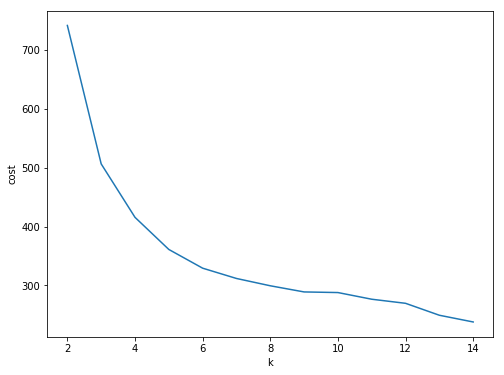

In [179]:
wsse = np.zeros(15)
for k in range(2,15):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = kmeans.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),wsse[2:15])
ax.set_xlabel('k')
ax.set_ylabel('cost')

### k = 7 from elbow method
### Train Model

In [180]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

for i in range(len(centers)):
    centers[i] = centers[i].tolist()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)
# type(centers)
transformed = model.transform(df_kmeans)
print(transformed.printSchema())
transformed = transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_k_means_k-8.csv", header=True)

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- 25: double (nullable = true)
 |-- 26: double (nullable = true)
 |-- 27: double (nullable = true)
 |-- 28: double (nullable = true)
 |-- 2

In [182]:
cluster_centroid_rdd = sc.parallelize(centers)
cluster_centroid_rdd = cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
df_cluster_center=sqlcontext.createDataFrame(cluster_centroid_rdd,new_Feature_cols)
len(centers)

8

In [183]:
scaled_feature_list = [list(row) for row in transformed.select("scaled_features").collect()]
scaled_feature_list = [[float(x) for x in list(row[0].values)] for row in scaled_feature_list]
avg_house_data = avg_house_data.drop("LCLid")
scaled_df = sc.parallelize(scaled_feature_list)
scaled_df = scaled_df.flatMap(lambda x : Row(x))
scaled_df = sqlcontext.createDataFrame(scaled_df,avg_house_data.schema)
scaled_df.printSchema()
type(scaled_feature_list[0][0])

root
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- 25: double (nullable = true)
 |-- 26: double (nullable = true)
 |-- 27: double (nullable = true)
 |-- 28: double (nullable = true)
 |-- 29: double (nullable = true)
 |-- 30: 

float

If we don't assign color all plot will be of different color,
by putting ax=ax we are plotting on same graph,
if removed new graph below will be plotted.

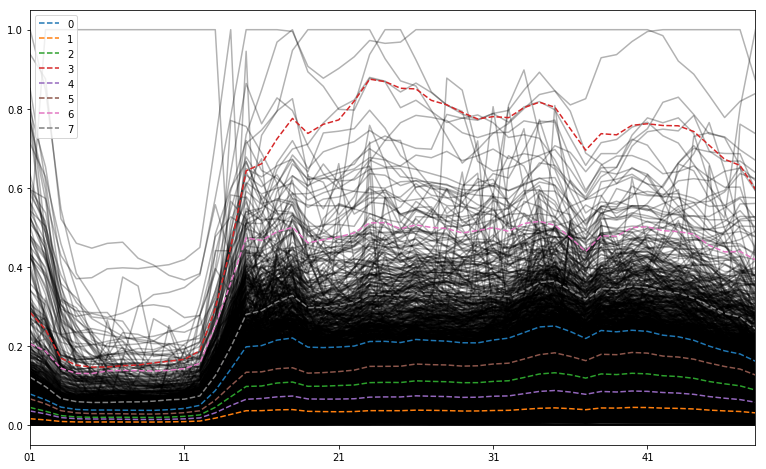

In [184]:
# ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
plot = df_cluster_center.toPandas().T.plot(ax=ax,alpha=1,style='--')

In [185]:
plot.get_figure().savefig(base_path+"../London_Smart_Meter_Load_Forecasting/cluster-8-means-scaled.png")

# Bisecting K-means

In [186]:
from pyspark.ml.clustering import BisectingKMeans

741.4036294122018
603.2077511359269
417.2312275376379
395.7334228222739
376.6990155176203
348.4097684478224
301.5665525936489
298.4948600197738
295.2821318100086
290.6705810225737
284.77625668173664
278.170638951305
271.4328698762977


Text(0, 0.5, 'cost')

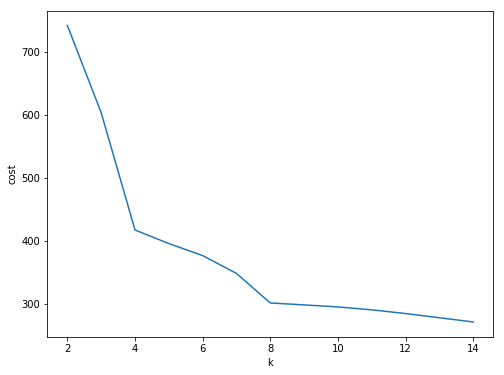

In [188]:
wsse = np.zeros(15)
for k in range(2,15):
    bkm = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = bkm.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),wsse[2:15])
ax.set_xlabel('k')
ax.set_ylabel('cost')

## k = 8 from elbow method

In [189]:
k = 8
bkm = BisectingKMeans().setK(8).setSeed(1).setFeaturesCol("scaled_features")
bkm_model = bkm.fit(df_kmeans)
bkm_cluster_center = bkm_model.clusterCenters()
bkm_transformed = bkm_model.transform(df_kmeans)
bkm_transformed = bkm_transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
bkm_transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_b-k_means_k-8.csv", header=True)

In [190]:
print(len(bkm_cluster_center))

8


In [191]:
for i in range(len(bkm_cluster_center)):
    bkm_cluster_center[i] = bkm_cluster_center[i].tolist()
bkm_cluster_centroid_rdd = sc.parallelize(bkm_cluster_center)
bkm_cluster_centroid_rdd = bkm_cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
bkm_df_cluster_center=sqlcontext.createDataFrame(bkm_cluster_centroid_rdd,new_Feature_cols)

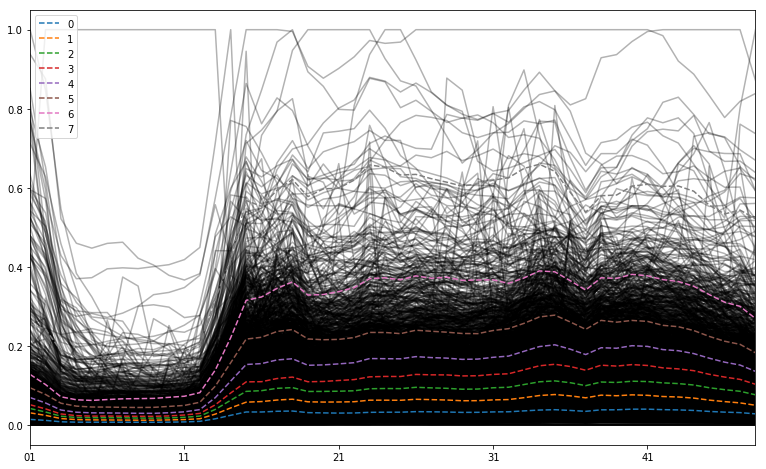

In [192]:
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
plot = bkm_df_cluster_center.toPandas().T.plot(ax=ax,alpha=1,style='--')

In [193]:
plot.get_figure().savefig(base_path+"../London_Smart_Meter_Load_Forecasting/cluster-8bk-means-scaled.png")